# 贷款预测之EDA

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [83]:
train = pd.read_csv('../dataset/train.csv', header=0, index_col='Loan_ID')

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


In [85]:
# 目标变量
target_var = 'Loan_Status'

# 分类变量
cat_col = train.select_dtypes(include=['object']).columns.tolist()
cat_col.remove(target_var)
# 连续变量
num_col = train.select_dtypes(exclude=['object']).columns.tolist()

In [86]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


1. ApplicantIncome和CoapplicantIncome的方差都很大，说明它们分布很广，可能存在离群值;<br>
2. 大部分的借款时长都在360;<br>
3. 84%的人有借款记录，68%的人贷款申请成功

In [87]:
train.describe(include=[object])

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,601,611,599,614,582,614,614
unique,2,2,4,2,2,3,2
top,Male,Yes,0,Graduate,No,Semiurban,Y
freq,489,398,345,480,500,233,422


In [88]:
num_col.remove('Credit_History')
cat_col.append('Credit_History')
train.dropna(axis=0, inplace=True)
train[target_var] = train[target_var].map({'Y':1, 'N':0})

从上表，大概可以看出每个分类变量的值有几种，最多的是哪类。<br><br>


## 变量分析

### 连续变量分析

In [89]:
for col in num_col:
    print('{}, skew={}'.format(col, train[col].skew()))

ApplicantIncome, skew=6.917026514199138
CoapplicantIncome, skew=5.881622127841592
LoanAmount, skew=2.3614368477871213
Loan_Amount_Term, skew=-2.333710422255636


In [90]:
log_numerical = train.copy()
log_numerical[num_col] = log_numerical[num_col].apply(lambda x: np.log1p(x))

In [91]:
for col in num_col:
    print('{}, skew={}'.format(col, log_numerical[col].skew()))

ApplicantIncome, skew=0.5651441603527614
CoapplicantIncome, skew=-0.15010350243127799
LoanAmount, skew=-0.3755444512878643
Loan_Amount_Term, skew=-3.94281715815386


In [92]:
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest
def get_p_value(data, columns, target):
    s1 = data.loc[data[target]==data[target].unique()[0], columns]
    s2 = data.loc[data[target]==data[target].unique()[1], columns]
    if len(s1)>30 and len(s2)>30:
        z, p = ztest(s1, s2)
    else:
        t, p = ttest_ind(s1, s2)
    return p

In [93]:
stats_result = pd.DataFrame(columns=['pvalue', 'P<0.05', 'col'])
for col in num_col:
    p = get_p_value(log_numerical, col, target_var)
    stats_result.loc[len(stats_result)] = [p, p<0.05, col]
stats_result.sort_values(by='pvalue', ascending=True)

,pvalue,P<0.05,col
1,0.180120,False,CoapplicantIncome
2,0.212455,False,LoanAmount
3,0.714281,False,Loan_Amount_Term
0,0.941874,False,ApplicantIncome


In [94]:
def plot_num(data, feature_name):
    s1 = data.loc[data[target_var]==1, feature_name]
    s2 = data.loc[data[target_var]==0, feature_name]
    s1mean = s1.mean()
    s1std = s1.std()
    s2mean = s2.mean()
    s2std = s2.std()
    print('Loan_Status==Yes, the mean={:.2f}(+/-{:.2f})'.format(s1mean, s1std))
    print('Loan_Status==No, the mean={:.2f}(+/-{:.2f})'.format(s2mean, s2std))
    if s1mean>s2mean:
        delta = s1mean-s2mean
    else:
        delta = s2mean-s1mean
    print('Absolute Mean Diferrence Distance: {:.2f}'.format(delta))
    print('p-value: {}'.format(stats_result.loc[stats_result['col']==feature_name, 'pvalue'].values[0]))
    print('p<0.05: {}'.format(stats_result.loc[stats_result['col']==feature_name, 'P<0.05'].values[0]))
    if feature_name in num_col:
        plt.figure(figsize=(15,5))
        _ = plt.subplot2grid((2,2),(0,0), rowspan=2)
        sns.pointplot(x=target_var, y=feature_name, data=data)
        
        _ = plt.subplot(2,2,2)
        sns.boxplot(y=feature_name, x=target_var, data=data)
        
        _ = plt.subplot(2,2,4)
        sns.kdeplot(data=data.loc[data[target_var]==1, feature_name], label='Y', shade=True)
        sns.kdeplot(data=data.loc[data[target_var]==0, feature_name], label='N', shade=True)
    else:
        plt.figure(figsize=(15,5))
        _ = plt.subplot2grid((2,2),(0,0), rowspan=2)
        sns.pointplot(x=target_var, y=feature_name, data=data)
        
        _ = plt.subplot(2,2,2)
        sns.boxplot(y=feature_name, x=target_var, data=data)
        
        _ = plt.subplot(2,2,4)
        sns.countplot(x=data.loc[data[target_var]==1, feature_name], data=df_train, color='darkgray')
        sns.countplot(x=data.loc[data[target_var]==0, feature_name], data=df_train, color='yellow')

#### ApplicantIncome

Loan_Status==Yes, the mean=5201.09(+/-4584.82)
Loan_Status==No, the mean=5730.19(+/-7560.81)
Absolute Mean Diferrence Distance: 529.10
p-value: 0.9418738855207953
p<0.05: False


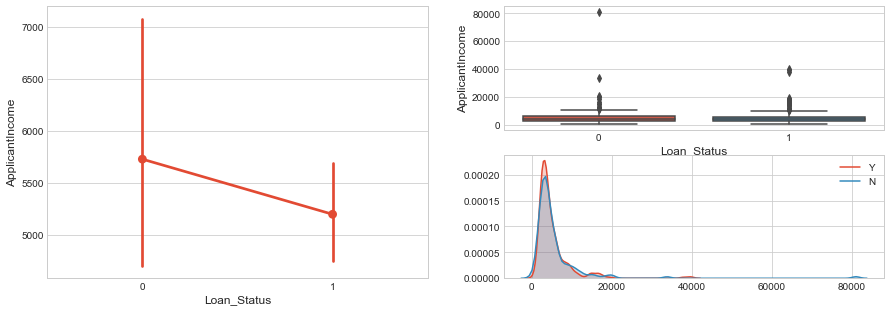

In [95]:
plot_num(train, 'ApplicantIncome')

ApplicantIncome不是贷款成功的关键，不论申请是否成功，申请者在ApplicantIncome的平均值上没有明显从差别。

#### CoapplicantIncome

Loan_Status==Yes, the mean=1495.51(+/-1982.74)
Loan_Status==No, the mean=1773.08(+/-3663.69)
Absolute Mean Diferrence Distance: 277.57
p-value: 0.1801203928842925
p<0.05: False


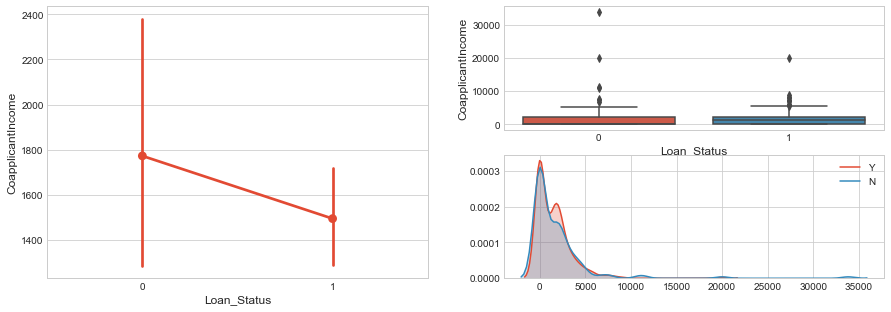

In [96]:
plot_num(train, 'CoapplicantIncome')

CoapplicantIncome的情况和ApplicantIncome类似，但是申请成功者的中位数更高一些。<br>

#### LoanAmount

Loan_Status==Yes, the mean=140.88(+/-75.54)
Loan_Status==No, the mean=153.38(+/-90.34)
Absolute Mean Diferrence Distance: 12.50
p-value: 0.2124547814911244
p<0.05: False


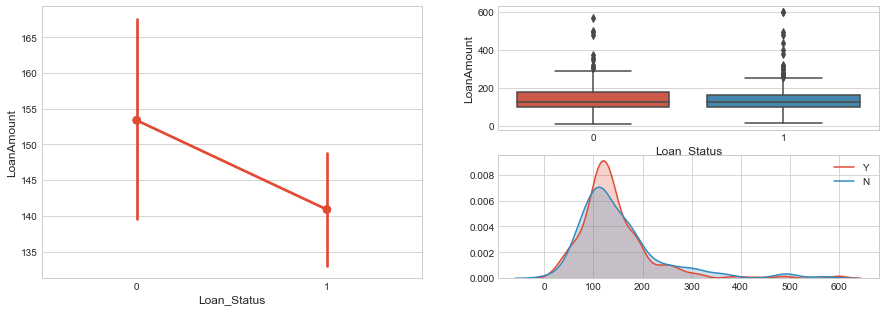

In [97]:
plot_num(train, 'LoanAmount')

#### Loan_Amount_Term

Loan_Status==Yes, the mean=341.71(+/-61.65)
Loan_Status==No, the mean=342.81(+/-72.79)
Absolute Mean Diferrence Distance: 1.10
p-value: 0.714280537202858
p<0.05: False


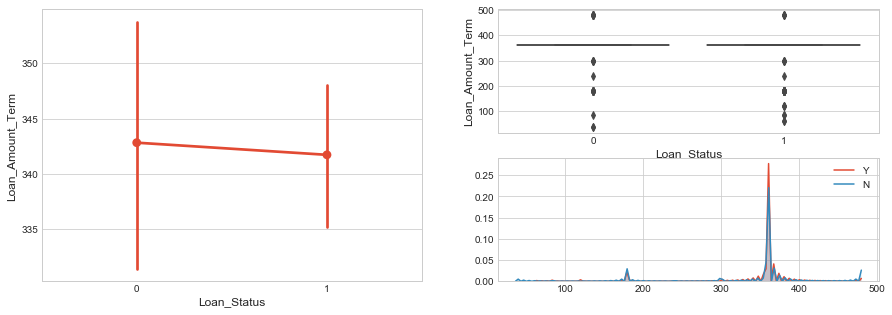

In [98]:
plot_num(train, 'Loan_Amount_Term')

### 分类变量分析

In [99]:
def get_chi2_value(data, columns, target=target_var):
    crosstable = pd.crosstab(data[columns], data[target])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    return p

In [100]:
from scipy.stats import chi2_contingency
chi2_result = pd.DataFrame(columns=['pvalue', 'P<0.05', 'col'])
for col in cat_col:
    crosstable = pd.crosstab(train[col], train[target_var])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    chi2_result.loc[len(chi2_result)] = [p, p<0.05, col]
chi2_result.sort_values(by='pvalue', ascending=True)

,pvalue,P<0.05,col
6,2.135982e-30,True,Credit_History
5,2.213959e-03,True,Property_Area
1,1.840546e-02,True,Married
3,1.687240e-01,False,Education
0,1.990183e-01,False,Gender
2,4.072100e-01,False,Dependents
4,5.371943e-01,False,Self_Employed


分类变量比连续变量情况好，Credit_History， Property_Area和Married与目标变量统计不独立，其他分类变量与目标变量统计不显著，不相关。

In [101]:
def plot_cat(data, feature_name):
    p = get_chi2_value(data, feature_name)
    crosstable = pd.crosstab(data[feature_name], data[target_var])
#     chi2, p, dof, expected = chi2_contingency(crosstable)
    # 不同特征值间离职和未离职的比例
    crosstable = crosstable.div(crosstable.sum(1), axis=0).round(4)
    crosstable.columns = ['No', 'Yes']
    print('\n 分类比例')
    print(crosstable)
    
    # 不同特征值在总体样本中所在比例
    percentage = (data[feature_name].value_counts() / len(data)).round(4)
    # 累计比例
    cumsum = percentage.cumsum().round(4)
    
    
    counttable = pd.DataFrame({'percentage': percentage, 'cumsum':cumsum},
                              index=data[feature_name].value_counts().index,
                              columns=['percentage', 'cumsum'])
    print('\n计数比例')
    print(counttable)
    
    yes_table = data[data[target_var]==1].groupby(feature_name)[target_var].sum()
    yes_percentage = (yes_table/yes_table.sum()).round(4)
    yestable = pd.DataFrame({'percentage': yes_percentage},
                            index=yes_table.index)
    yestable2 = yestable.reindex(index=counttable.index)
    yestable2['cumsum'] = yestable2['percentage'].cumsum()
    print('\n申请成功')
    print(yestable2)
    
    plt.figure(figsize=(15,7))
    ax1 = plt.subplot(2,2,1) # plt.subplot2grid((2,2),(0,0), rowspan=2)
    crosstable.plot(kind='bar', stacked=True, ax=ax1, rot=0)
    ax1.set_ylim([0,1.1])
    
    _ = plt.subplot(2,2,3)
    sns.barplot(x=feature_name, y=target_var, data=data, errwidth=0)
        
    _ = plt.subplot(2,2,2)
    sns.countplot(x=feature_name, data=data)

    _ = plt.subplot(2,2,4)
    sns.countplot(x=feature_name, data=data, hue=target_var)

#### Credit_History


 分类比例
                    No     Yes
Credit_History                
0.0             0.9000  0.1000
1.0             0.2073  0.7927

计数比例
     percentage  cumsum
1.0      0.8542  0.8542
0.0      0.1458  1.0000

申请成功
     percentage  cumsum
1.0      0.9789  0.9789
0.0      0.0211  1.0000


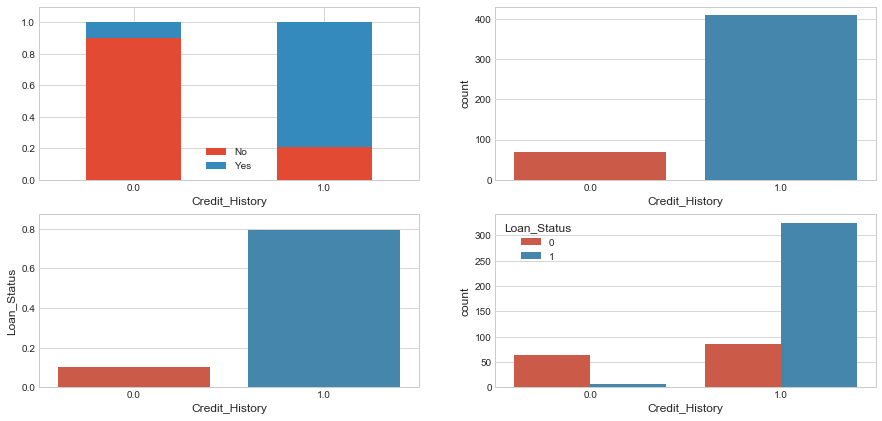

In [102]:
plot_cat(train, 'Credit_History')

Credit_History和贷款申请是否成功有重要关系。<br>
在有信用记录的用户中，79%贷款申请成功，而没有信用记录的用户中，这一比例只有10%。有贷款记录的申请成功率是没有贷款记录的8倍。<br>
在申请成功的用户中，有贷款记录的用户占98%。

#### Property_Area


 分类比例
                   No     Yes
Property_Area                
Rural          0.3885  0.6115
Semiurban      0.2199  0.7801
Urban          0.3467  0.6533

计数比例
           percentage  cumsum
Semiurban      0.3979  0.3979
Urban          0.3125  0.7104
Rural          0.2896  1.0000

申请成功
           percentage  cumsum
Semiurban      0.4488  0.4488
Urban          0.2952  0.7440
Rural          0.2560  1.0000


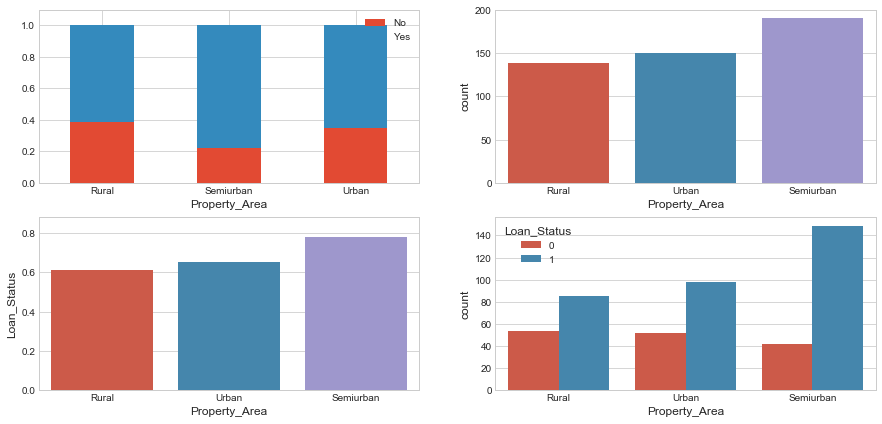

In [103]:
plot_cat(train, 'Property_Area')

住在Semiurban的申请者贷款申请成功率最高，而在Rural的成功率最低。

#### Married


 分类比例
             No     Yes
Married                
No       0.3787  0.6213
Yes      0.2701  0.7299

计数比例
     percentage  cumsum
Yes      0.6479  0.6479
No       0.3521  1.0000

申请成功
     percentage  cumsum
Yes      0.6837  0.6837
No       0.3163  1.0000


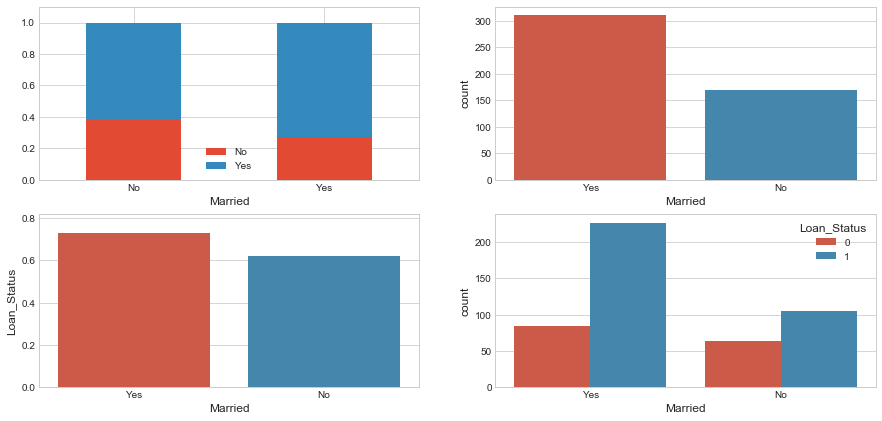

In [104]:
plot_cat(train, 'Married')

已婚申请者的成功率高于未婚的申请者。

#### Education


 分类比例
                  No     Yes
Education                   
Graduate      0.2924  0.7076
Not Graduate  0.3711  0.6289

计数比例
              percentage  cumsum
Graduate          0.7979  0.7979
Not Graduate      0.2021  1.0000

申请成功
              percentage  cumsum
Graduate          0.8163  0.8163
Not Graduate      0.1837  1.0000


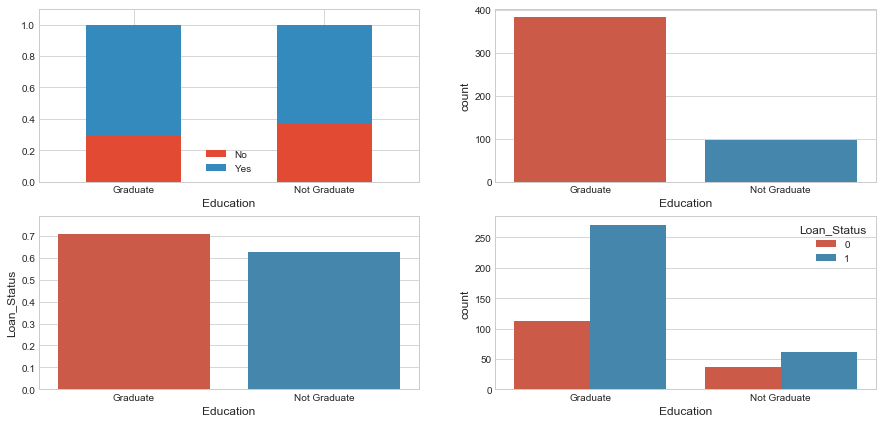

In [105]:
plot_cat(train, 'Education')

#### Gender


 分类比例
            No     Yes
Gender                
Female  0.3721  0.6279
Male    0.2944  0.7056

计数比例
        percentage  cumsum
Male        0.8208  0.8208
Female      0.1792  1.0000

申请成功
        percentage  cumsum
Male        0.8373  0.8373
Female      0.1627  1.0000


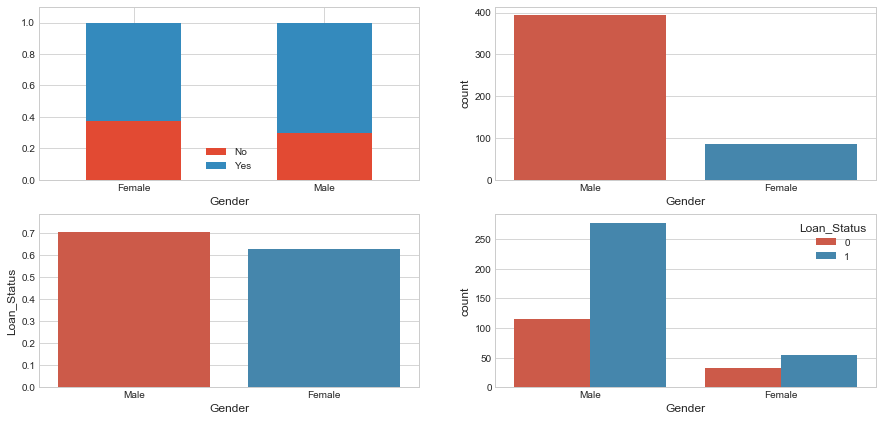

In [106]:
plot_cat(train, 'Gender')

#### Dependents


 分类比例
                No     Yes
Dependents                
0           0.3175  0.6825
1           0.3500  0.6500
2           0.2353  0.7647
3+          0.3171  0.6829

计数比例
    percentage  cumsum
0       0.5708  0.5708
2       0.1771  0.7479
1       0.1667  0.9146
3+      0.0854  1.0000

申请成功
    percentage  cumsum
0       0.5633  0.5633
2       0.1958  0.7591
1       0.1566  0.9157
3+      0.0843  1.0000


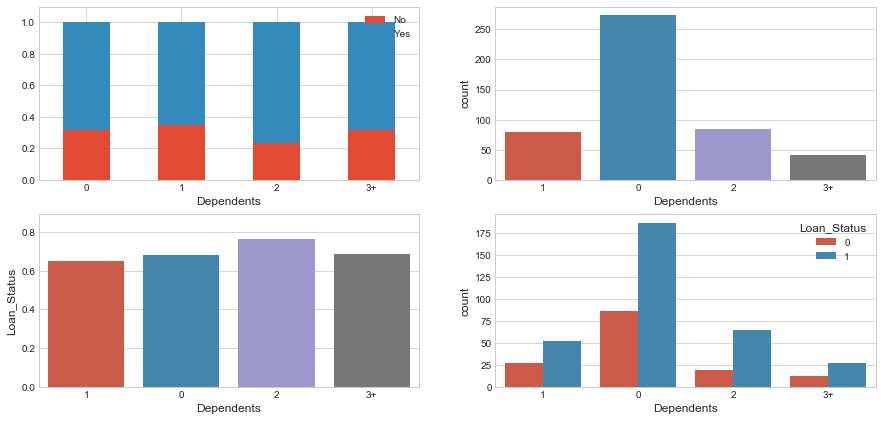

In [107]:
plot_cat(train, 'Dependents')

#### Self_Employed


 分类比例
                   No     Yes
Self_Employed                
No             0.3019  0.6981
Yes            0.3485  0.6515

计数比例
     percentage  cumsum
No       0.8625  0.8625
Yes      0.1375  1.0000

申请成功
     percentage  cumsum
No       0.8705  0.8705
Yes      0.1295  1.0000


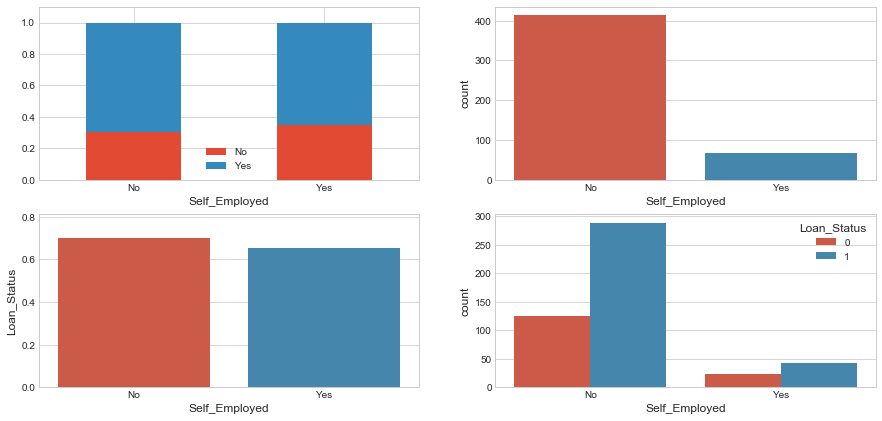

In [108]:
plot_cat(train, 'Self_Employed')

## 组合变量分析
### TotolIncome

Loan_Status==Yes, the mean=6696.60(+/-4684.60)
Loan_Status==No, the mean=7503.27(+/-8140.41)
Absolute Mean Diferrence Distance: 806.67
p-value: 0.17120104898799515
p<0.05: False


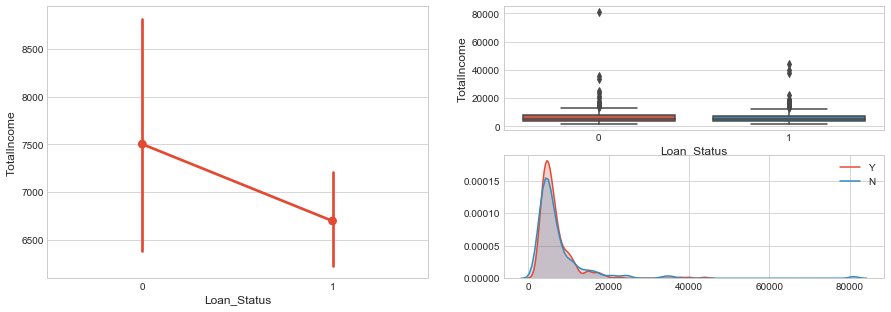

In [110]:
num_col.append('TotalIncome')
train['TotalIncome'] = train['ApplicantIncome'] + train['CoapplicantIncome']
p = get_p_value(train, 'TotalIncome', target_var)
stats_result.loc[len(stats_result)] = [p, p<0.05, 'TotalIncome']
plot_num(train, 'TotalIncome')

#### TotolIncome & Property_Area

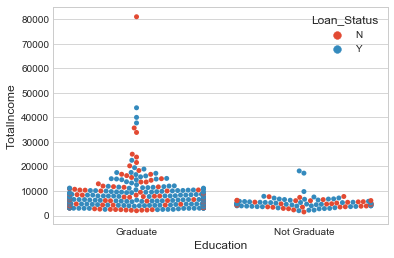

In [82]:
sns.swarmplot(x='Education', y='TotalIncome', data=train, hue=target_var)

Married        No       Yes
Gender                     
Female   0.471458  0.528542
Male     0.461641  0.538359
Dependents         0         1         2        3+
Gender                                            
Female      0.232558  0.219269  0.182724  0.365449
Male        0.247957  0.235303  0.276648  0.240091
Education  Graduate  Not Graduate
Gender                           
Female     0.471014      0.528986
Male       0.540793      0.459207
Self_Employed        No       Yes
Gender                           
Female         0.564706  0.435294
Male           0.508479  0.491521
Property_Area     Rural  Semiurban     Urban
Gender                                      
Female         0.305556   0.391414  0.303030
Male           0.296621   0.382896  0.320483
Credit_History       0.0       1.0
Gender                            
Female          0.088452  0.911548
Male            0.117497  0.882503
Dependents         0         1         2        3+
Married                                  

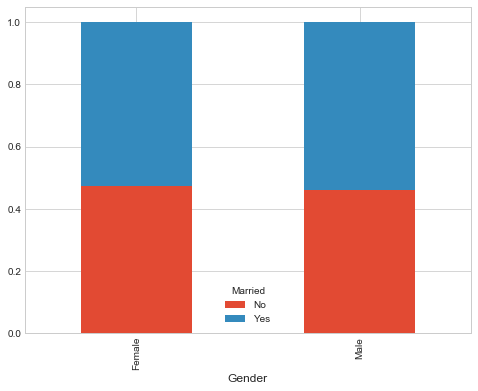

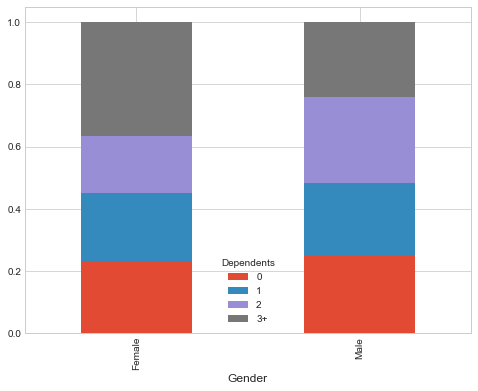

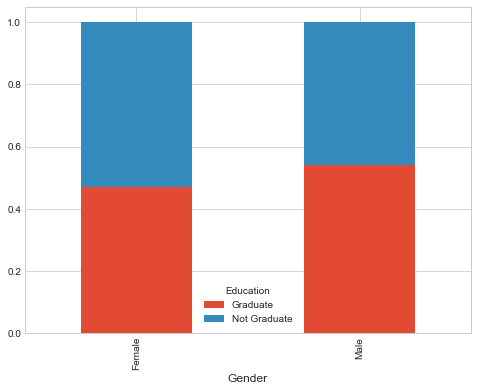

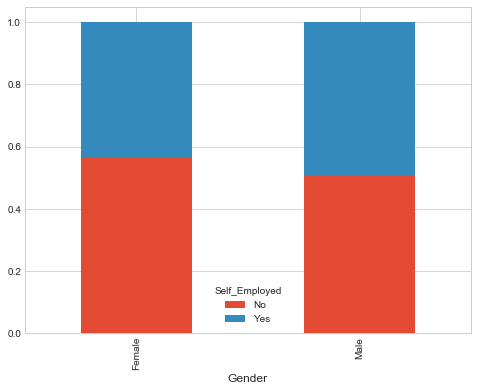

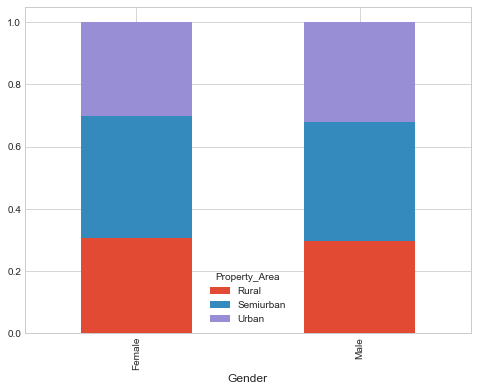

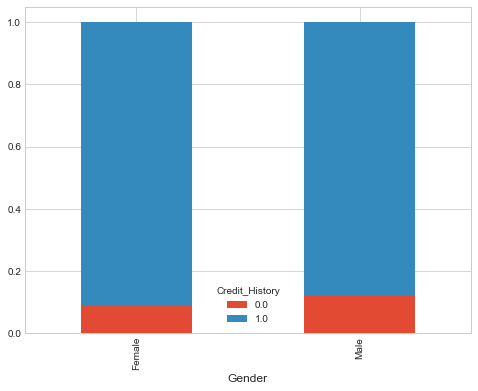

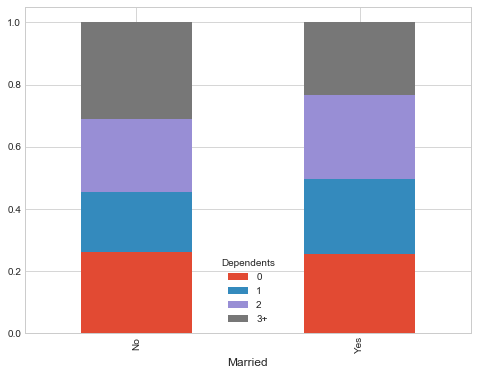

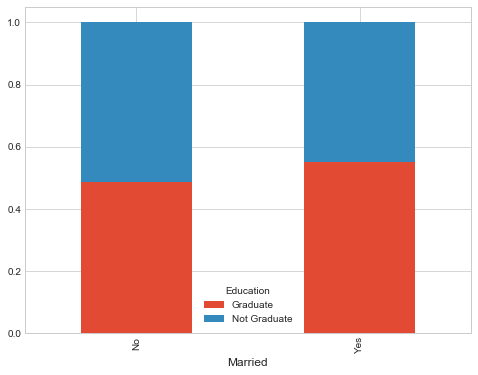

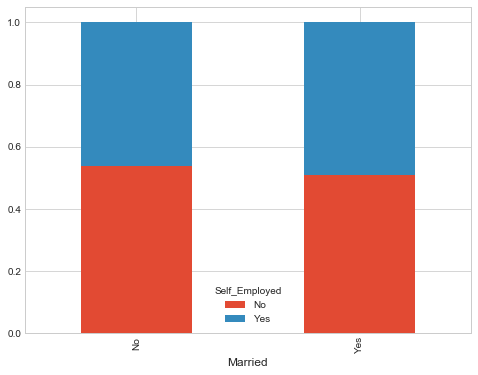

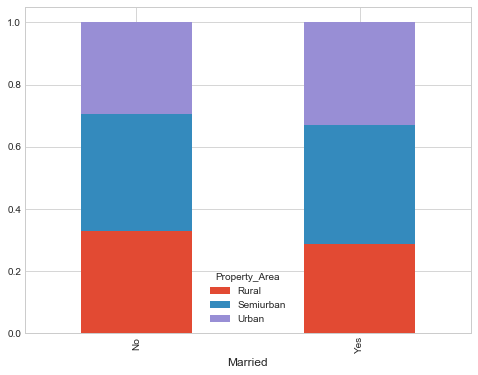

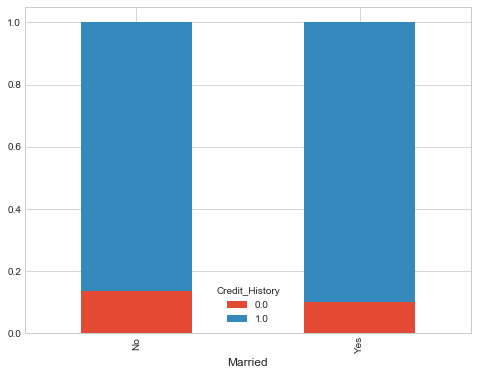

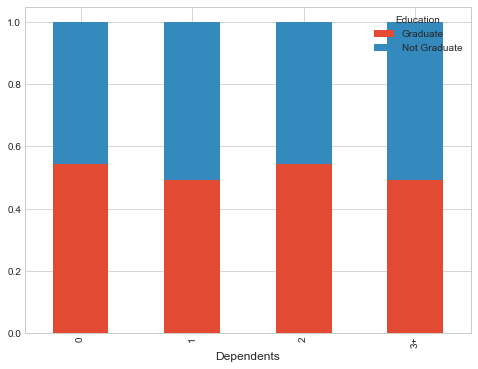

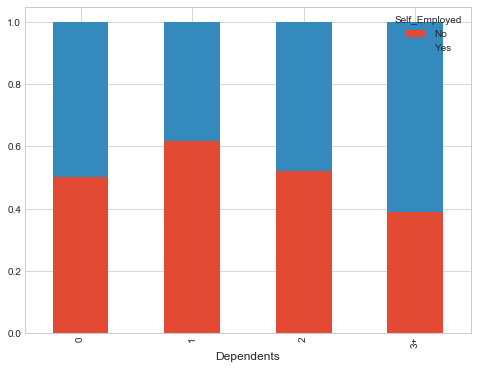

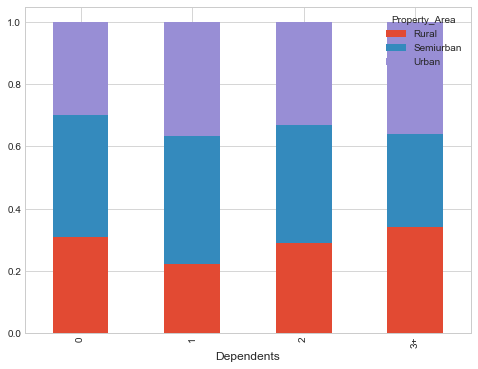

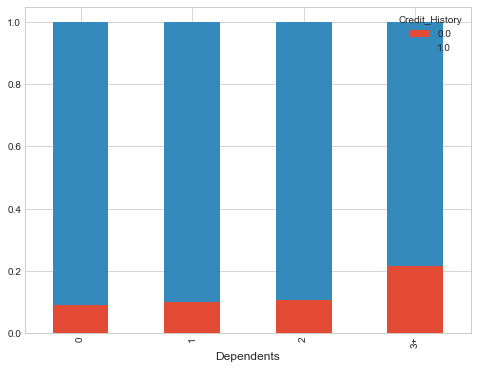

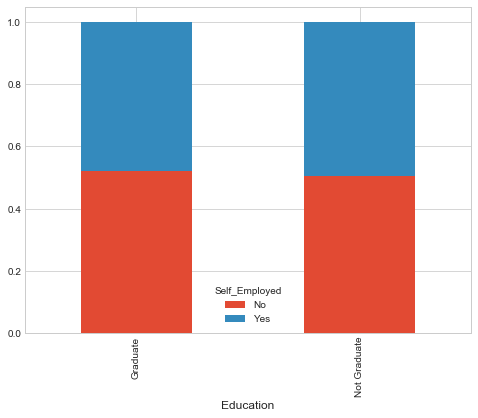

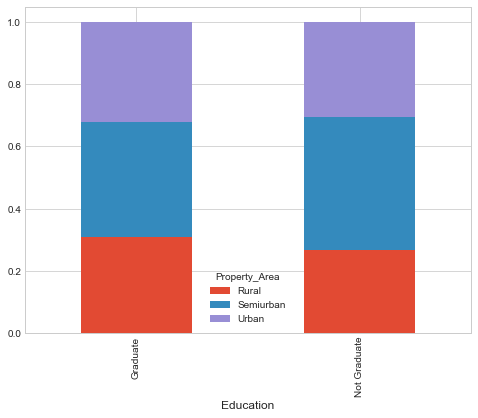

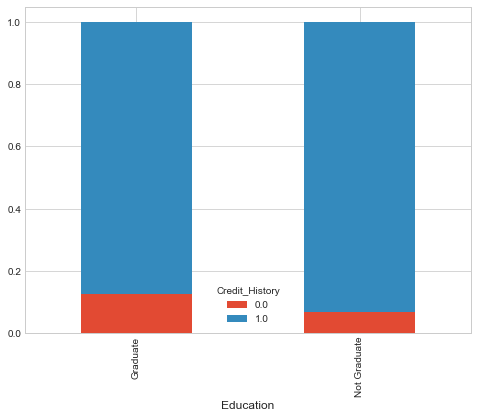

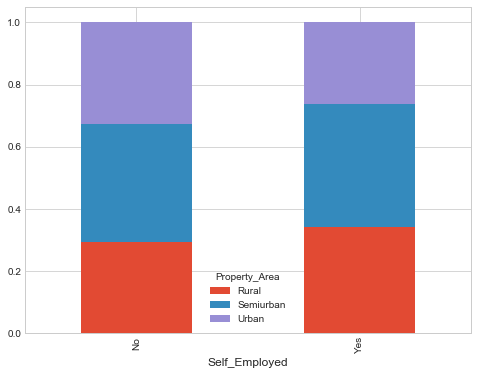

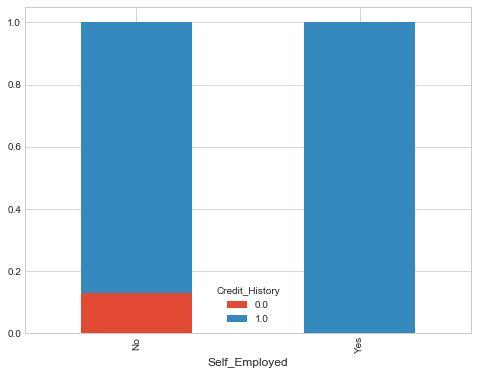

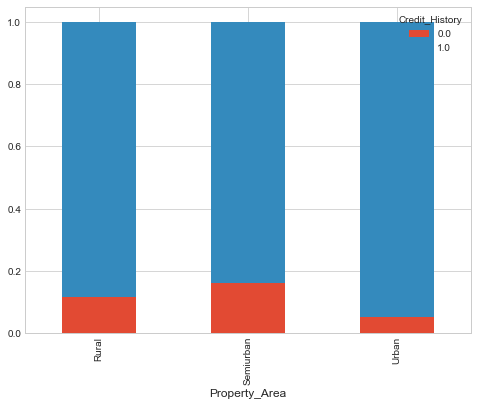

In [119]:
n = len(cat_col)
for x in range(n):
    for y in range(x, n):
        if x>=y: continue
        pivotable = pd.pivot_table(index=cat_col[x], columns=cat_col[y], values=target_var, data=train)
        pivotable = pivotable.div(pivotable.sum(1), axis=0)
        print(pivotable)
        pivotable.plot(kind='bar',stacked=True, figsize=(8,6))

In [72]:
cat_col

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Credit_History']

## 缺失值的处理

In [ ]:
# 将字符变量转化为数值型
le = LabelEncoder()
not_missing_var = [x for x in cat_cal+num_col if sum(df[x].isnull())==0\
                                         and x in cat_cal]
for col in not_missing_var:
    df[col] = le.fit_transform(df[col])

用随机森林对缺失值进行填充。

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
def fill_miss_var(df):
    predictors = [x for x in cat_cal+num_col if sum(df[x].isnull())==0]
    
    missing_var = [x for x in cat_cal+num_col if sum(df[x].isnull())!=0]
    
    for outcome in missing_var:
        #Fit the model:
        clf = RandomForestClassifier(random_state=45, n_estimators=50, n_jobs=-1)
        
        train_df = df[df[outcome].notnull()]
        test_df = df[df[outcome].isnull()]
    
        clf.fit(train_df[predictors],train_df[outcome])
    
        #Make predictions on training set:
        predictions = clf.predict(test_df[predictors]) 
        df.loc[df[outcome].isnull(),outcome]=predictions
    
    return df

df = fill_miss_var(df)

In [ ]:
df.head()

In [ ]:
# 为分类变量创建虚拟变量
for col in categories_var:
    dummies = pd.get_dummies(data=df[col],prefix=col)
    dummies.drop([dummies.iloc[:,0].name], axis=1, inplace=True)
    df = pd.concat([df,dummies],axis=1)
    df.drop([col],axis=1,inplace=True)
    
# 将连续变量标准化
stand_enc = StandardScaler()

for col in continuities_var:
    df[col] = stand_enc.fit_transform(np.array(df[col]).reshape(-1,1).astype(float64))

## 建立模型
用Skicit-Learn（sklearn）建立机器学习模型。
sklearn要求所有的输入都是数值型，所以首先需要对数据集进行编码。

In [ ]:
# 定义预测和验证函数
def classification_model(model,df,predictor,outcome):
    X_train, X_test, y_train, y_test = train_test_split(df[predictor], df[outcome], test_size=0.3)
    
    model.fit(X_train, y_train)
    result = model.predict(X_test)
    score = model.score(X_test, y_test)
    print('预测准确率是:%.4f'%score)
    report = metrics.classification_report(y_test, result)
    print('='*50)
    print('验证报告')
    print(report)
    matrix = metrics.confusion_matrix(y_test, result)
    print('='*50)
    print('混淆矩阵:')
    print(matrix)
    
    # 输出预测错的样本
    df = pd.read_csv('./dataset/train_set.csv', header=0, index_col='Loan_ID')
    bad_index = y_test.loc[result != y_test].index.tolist()
    bad_cases = df.loc[bad_index, :]
    return model, bad_cases

def predictor_result(clf,df,predictors):
    target = clf.predict(df[predictors])
    result = DataFrame({'Loan_Status':target}, index=df.index)
    result.to_csv('Submissions.csv')

In [ ]:
train_df = df.loc[df['source']=='train'].copy()
test_df = df.loc[df['source']=='test'].copy()

train_df.drop(['source'], axis=1, inplace=True)
test_df.drop(['source'], axis=1, inplace=True)

### Logistic回归

In [ ]:
predictor_var=[x for x in train_df.columns if x !=target_var]
model = LogisticRegression(C=1, penalty='l1', tol=1e-6)
clf, badbases = classification_model(model, train_df, predictor_var, target_var)
#pd.DataFrame({"columns":predictor_var, "coef":list(clf.coef_.T)})

In [ ]:
predictor_result(clf, test_df, predictor_var)

上传结果，得分是** <font color='red'>0.7847</font> **，不算很差。<br>
这个只是没有做任何特征提取和特征工程的baseline，看看其他人的结果，应该还有提升的空间。<br>
现在分析baseline模型拟合情况，绘制学习曲线。

In [ ]:
va.plot_learning_curve(model, 'lr', train_df[predictor_var], train_df[target_var])

从学习曲线上看，baseline模型没有处于过拟合的状态，还可以在做一些特征提取和特征工程，添加新的特征到模型中。<br>
观察模型得到的各个特征的系数，因为系数能够展现特征与预测结果的关系及关系强弱。

In [ ]:
coef = pd.DataFrame({"columns":predictor_var, "coef":list(clf.coef_[0])})
coef.to_csv('coef.csv')

从系数的绝对值大小依次分析，
1. Credit_History_0.0对结果的影响最大，并且是负相关，也就是说，如果Credit_History = 0， 预测结果更可能是0；
2. 其次是Property_Area,房产的位置也会影响到贷款申请，可能是因为不同区域的房产，价格不一样，能够提供的担保不一样，这个变量也可以再挖掘；
3. Married与否和结果分别是正负相关，因此这个结果结论也可以深挖；
4. Dependents_1与结果是负相关，其他值对结果没有影响，但是在单变量分析的时候，没有发现各个值之间有很大的变化，也许是挖掘不够；
5. Education与Married一样，分别是正负相关；
6. 三个连续特征对结果的影响不大；
7. 只有Self_Employed_Yes对结果有影响，应该也需要和其他特征结合，生成新变量；
8. 性别对结果完全没有影响，这个和前面的变量分析是一致的；
9. 只有Loan_Amount_Term_180.0和Loan_Amount_Term_480.0对结果有影响。

结合系数的分析，可以尝试：
1. 将ApplicantIncome和CoapplicantIncome相加，求总的收入；
2. 

In [ ]:
train_df = pd.read_csv('./dataset/train_set.csv', header=0, index_col='Loan_ID')
test_df = pd.read_csv('./dataset/test_set.csv', header=0, index_col='Loan_ID')

train_df['source'] = 'train'
test_df['source'] = 'test'

df = pd.concat([train_df, test_df],axis=0)

train_df['Loan_Status'] = train_df['Loan_Status'].map({'Y':1,'N':0}).astype('int32')

In [ ]:
df.dropna(inplace=True)
for col in categories_var:
    df[col] = le.fit_transform(df[col])

fig = plt.figure(figsize=(8,8))
sns.heatmap(df[continuities_var].corr(), annot=True)

从上图看出，ApplicantIncome和LoanAmount的相关系数是0.5，说明两者存在一定的正相关。

In [ ]:
g = sns.FacetGrid(df, size=5)
g.map(plt.scatter, 'ApplicantIncome', 'LoanAmount', alpha=0.7)

从上图可以看出，ApplicantIncome和LoanAmount呈线性关系，并且ApplicantIncome没有缺失值，可以用ApplicantIncome来预测LoanAmount的值。<br>
申请贷款时，如果是综合收入也许和贷款金额有一些关系，因此考虑ApplicantIncome+CoapplicantIncome的情况。在上面的单变量分析中，ApplicantIncome，CoapplicantIncome和LoanAmount都不是正态分布，而且有离群值存在，因此作对数变换。

In [ ]:
df['TotalIncome'] = np.log(df['ApplicantIncome'] + df['CoapplicantIncome'])
df['LoanAmount'] = np.log(df['LoanAmount']*1000)
g = sns.FacetGrid(df, size=5)
(g.map(plt.scatter, 'TotalIncome', 'LoanAmount', alpha=0.7)).add_legend()

In [ ]:
# 用线性回归方式填充LoanAmount
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
X_train = np.array(df.loc[df['LoanAmount'].isnull()==False, 'TotalIncome']).reshape(-1,1)
y_train = np.array(df.loc[df['LoanAmount'].isnull()==False, 'LoanAmount']).reshape(-1,1)
X_test = np.array(df.loc[df['LoanAmount'].isnull()==True, 'TotalIncome']).reshape(-1,1)
clf.fit(X_train, y_train)
df.loc[df['LoanAmount'].isnull()==True, 'LoanAmount'] = clf.predict(X_test)

In [ ]:
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

df['Dependents'] = le.fit_transform(df['Dependents'])
df['Dependents'] = df['Dependents']+1
df['Property_Area'] = le.fit_transform(df['Property_Area'])
df['Property_Area'] = df['Property_Area'] + 1
df['TotalIncome'] = (df['ApplicantIncome'] + df['CoapplicantIncome'])*df['Property_Area']
df['return']=df['LoanAmount']*1000/df['Loan_Amount_Term']
df['temp']=df['TotalIncome']/df['Dependents']
df['radio']=df['temp']/df['return']
#df[['return', 'temp', 'radio', 'Loan_Amount_Term', 'Loan_Status','Dependents']]

In [ ]:
train_df = df.loc[df['source']=='train'].copy()
#train_df['Dependents'] = le.fit_transform(train_df['Dependents'])
g = sns.FacetGrid(train_df, hue='Loan_Status', size=8)
(g.map(plt.scatter, 'temp', 'return', alpha=0.3)).add_legend()
#sns.violinplot(x='Property_Area', y='radio', hue='Loan_Status', data=train_df, split=True)

In [ ]:
df['Credit_History'].fillna(df['Credit_History'].mode(), inplace=True)
df['Dependents'].fillna(df['Dependents'].mode(), inplace=True)
df['Gender'].fillna(df['Gender'].mode(), inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode(), inplace=True)
df['Married'].fillna(df['Married'].mode(), inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode(), inplace=True)

# 总收入
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['IncomeBand'] = pd.qcut(df['TotalIncome'], q=[.25,.5,.75,1])

df['AmountBand'] = pd.qcut(df['LoanAmount'], q=[.25,.5,.75,1])

df['radio'] = df['TotalIncome']/(df['LoanAmount'] * 1000.0 / df['Loan_Amount_Term'])

#continuities_var.append('TotalIncome')
#continuities_var.append('radio')
#for col in continuities_var:
#    df[col] = stand_enc.fit_transform(np.array(df[col]).reshape(-1,1).astype(float64))


df.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome'], axis=1, inplace=True)


columns = [x for x in df.columns if x not in [target_var, 'source']]
for col in columns:
    dummies = pd.get_dummies(data=df[col],prefix=col)
    df = pd.concat([df,dummies],axis=1)
    df.drop([col],axis=1,inplace=True)
#
#df.drop(['Credit_History_1.0'],axis=1,inplace=True)
#df.drop(['Gender_Female'], axis=1, inplace=True)
#df.drop(['Married_Yes'], axis=1, inplace=True)
#df.drop(['Dependents_3+'], axis=1, inplace=True)
#df.drop(['Education_Graduate'], axis=1, inplace=True)
#df.drop(['Self_Employed_No'], axis=1, inplace=True)
#df.drop(['Property_Area_Semiurban'], axis=1, inplace=True)
#df.drop(['Loan_Amount_Term_6.0'], axis=1, inplace=True)

In [ ]:
df.head(2)

In [ ]:
train_df = df.loc[df['source']=='train'].copy()
test_df = df.loc[df['source']=='test'].copy()

train_df.drop(['source'], axis=1, inplace=True)
test_df.drop(['source'], axis=1, inplace=True)

In [ ]:
predictor_var=[x for x in train_df.columns if x !=target_var]
model = LogisticRegression(C=0.1, penalty='l1', tol=1e-6)
clf, badbases = classification_model(model, train_df, predictor_var, target_var)

In [ ]:
def urban(area):
    a, b = area
    return 0 if a == 1 and b == 1 else 1
df['Urban'] = df[['Credit_History_0.0','Property_Area_2']].apply(urban, axis=1)

In [ ]:
train_df = df[df['source']=='train']
test_df = df[df['source']=='test']

train_df.drop(['source'], axis=1, inplace=True)
test_df.drop(['source'], axis=1, inplace=True)

In [ ]:
predictor_var=[x for x in train_df.columns if x !=target_var]
model = LogisticRegression(C=1,penalty='l1', tol=1e-6)
clf = classification_model(model,train_df,predictor_var,target_var)

根据不同特征的权重值，在模型上：
* Credit_History 与结果是强正相关，即有贷款历史的申请者更容易申请到贷款。
* LoanAmount和Loan_Amount_Term与结果是负相关，即贷款量越小，贷款期限越短，越容易申请到贷款。Loan_Amount_Term的影响比LoanAmount更小。
* 学历高对贷款状态的影响不明显，但是低学历会影响到贷款状态。
* 居住在Semiurban更容易获得贷款，Rural和Urban对和状态是负相关。
* Dependents=1时不容易获得贷款。
* 性别和结果都是负相关，因此性别对结果的影响不大。
* 未婚申请者的申请成功概率更低。
* Self_Employed对结果没有影响。
* TotalIncome和结果是正相关。

In [ ]:
param_test1 = {'C':[0.1,0.5,1,5,10]}
gsearch1 = GridSearchCV(estimator = \
                        LogisticRegression(penalty='l1',tol=1e-6),param_grid=param_test1,cv=5)
gsearch1.fit(train_df[predictor_var],train_df[outcome_var])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {'verbose':range(0,5,1),'tol':[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8],'C':[0.1,0.5,1,5,10],
              'random_state':range(0,20,2)}
gsearch1 = GridSearchCV(estimator = LogisticRegression(penalty='l1'),
                        param_grid=param_test1,
                        cv=5)
gsearch1.fit(train_df[predictor_var],train_df[outcome_var])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
model = LogisticRegression(C=10,penalty='l1',tol=1e-6,random_state=10)

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=0)